<a href="https://colab.research.google.com/github/minhtpham/LinkedIn_Analysis/blob/main/Minh_Pham_LinkedIn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1.Housekeeping**

In [ ]:
from IPython.core.display import display, HTML
from pyvis import network as net
import networkx as nx

import plotly.express as px
import plotly.graph_objects as go

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
pip install --upgrade plotly

In [ ]:
import pandas as pd
import numpy as np 
import janitor
import datetime

In [ ]:
!pip3 install -U datapane
!pip install pyjanitor pyvis --quiet

In [ ]:
import datapane as dp

##### Load Data

In [ ]:
github_url = 'https://raw.githubusercontent.com/minhtpham/LinkedIn_Analysis/main/data/Connections.csv'

network = pd.read_csv(github_url)

##### Clean Data

In [ ]:
# Drop Null
network = network.dropna(subset = ['Company','Position'])

def convert(date):
    return datetime.datetime.strptime(date, "%d-%b-%y").strftime("%Y-%m-%d")

network["Connected On"] = network["Connected On"].apply(convert)

### **2. Exploratory Data Science**

##### **Connection Timeline**

In [ ]:
connection_timeline = px.line(
    network.groupby(by = 'Connected On').count().reset_index(),
    x = "Connected On",
    y = "First Name",
    labels = {"First Name":"Number"},
    title = 'My Connection Timelime'
)
connection_timeline.show()

I can see that I got motivated to connect and network with people on LinkedIn in phases. The rest of the time I'm recovering from networking :D

##### **Companies**

In [ ]:
company = network.groupby(by='Company').count().reset_index().sort_values(by='First Name', ascending=False).reset_index(drop=True)

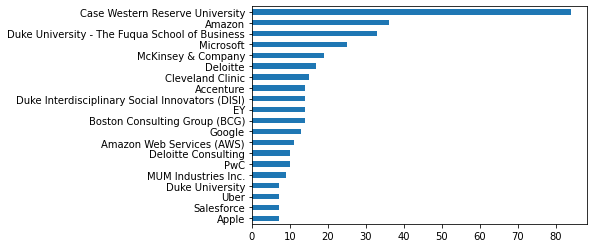

In [ ]:
network['Company'].value_counts().head(20).plot(kind="barh").invert_yaxis();

Lots of my connections are still at CWRU. Duke Fuqua School of Business is close!

In [ ]:
connection_treemap = px.treemap(
    company[:100], 
    path = ['Company', 'Position'],
    values = 'First Name',
    labels = {'First Name':'Number'}
)
connection_treemap

##### **Position**

In [ ]:
network['Position'].value_counts()[network['Position'].value_counts()/len(network) * 100 > 0.5]

Software Engineer              42
Research Assistant             41
Business Analyst               18
Founder                        18
Graduate Research Assistant    16
Product Manager                16
Consultant                     16
Associate                      14
MBA Candidate                  13
Project Manager                13
Software Engineer Intern       13
Teaching Assistant             12
Co-Founder                     10
Analyst                        10
Associate Product Manager       9
Data Analyst                    9
Name: Position, dtype: int64

In [ ]:
position_bar = px.bar(
    network.groupby(by = 'Position').count().sort_values(by = 'First Name', ascending = False)[:20].reset_index(),
    x = 'Position',
    y = 'First Name',
    labels = {'First Name' : 'Number'},
    title = 'Top 20 Positions'
)
position_bar

##### **Create Company and Position Dataframe for Visualization**

In [ ]:
company = network['Company'].value_counts().reset_index()
company.columns = ['company', 'count']
company = company.sort_values(by = 'count', ascending = False)
company_viz = company.loc[company['count'] >= 3]  # Only includes the companies that I know more than 3 people
company_viz = company_viz.drop(labels = 0, axis = 0) # Delete the 1st column (Case Western Reserve University) because I only want companies
print(company_viz.shape)

(60, 2)


In [ ]:
position = network['Position'].value_counts().reset_index()
position.columns = ['position', 'count']
position = position.sort_values(by = 'count', ascending = False)
position_viz = position.loc[position['count'] >= 3]
print(position_viz.shape)

(77, 2)


### **3. Visualize my Network**

##### **Learn how to make a network**

In [ ]:
g = nx.Graph()
g.add_node(0, label = 'Minh Pham')
g.add_node(1, label = 'Case Western Reserve University', size = 25, title = 'Undergraduate')
g.add_node(2, label = 'Duke University, Fuqua School of Business', size = 10, title = 'Grad School')
g.add_node(3, label = 'Mater Dei High School', size = 5, title = 'High School')
g.add_edge(0,1)
g.add_edge(0,2)
g.add_edge(0,3)

network_school = net.Network(notebook = True)
network_school.from_nx(g)
network_school.show('nodes.html')
display(HTML('nodes.html'))

##### **Visualize Company Network**

In [ ]:
g = nx.Graph()
g.add_node('Minh Pham')

for _, row in company_viz.iterrows():

  company = row['company']
  count = row['count']

  title = f"<b>{company}</b> – {count}"
  positions = set([x for x in network[company == network['Company']]['Position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#01009a') # Duke Blue color!
  g.add_edge('Minh Pham', company, color='grey')

company_network = net.Network(height='700px', width='1000px', bgcolor="white", font_color='black')
company_network.from_nx(g)
company_network.hrepulsion()
company_network.show('company_graph.html')
display(HTML('company_graph.html'))

##### **Visualize Job Title Network**

In [ ]:
g = nx.Graph()
g.add_node('Minh Pham')

for _, row in position_viz.iterrows():

  count = f"{row['count']}"
  position= row['position']

  title = f"<b>{position}</b> – {count}"

  companies = set([x for x in network[position == network['Position']]['Company']])
  companies = ''.join('<li>{}</li>'.format(x) for x in companies)
  company_list = f"<ul>{companies}</ul>"

  hover_info = title + company_list

  g.add_node(position, size=count, color='#01009a', title = hover_info) # Duke Blue color!
  g.add_edge('Minh Pham', position, color='grey')

position_network = net.Network(height='700px', width='1000px', bgcolor="white", font_color='black')
position_network.from_nx(g)
position_network.hrepulsion()
position_network.show('position_graph.html')
display(HTML('position_graph.html'))

##### **Use Datapane to publish visualization**

In [ ]:
!datapane login --server=https://datapane.com/ --token=''

Connected successfully to https://datapane.com as minhtpham


In [ ]:
def read_html(name: str):
    import codecs
    f = codecs.open(name, 'r')
    return f.read()

In [ ]:
viz1 = dp.Report(dp.HTML(read_html('company_graph.html')))
viz1.upload(name = 'linkedin_company_network')

viz2 = dp.Report(dp.HTML(read_html('position_graph.html')))
viz1.upload(name = 'linkedin_position_network')

Uploading report and associated data - *please wait...*
Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out https://docs.datapane.com/reports/blocks/layout-pages-and-selects for more info
Report successfully uploaded at https://datapane.com/u/minhtpham/reports/J35lgLA/linkedin-company-network/, follow the link to view and share your report.
Uploading report and associated data - *please wait...*
Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out https://docs.datapane.com/reports/blocks/layout-pages-and-selects for more info
Report successfully uploaded at https://datapane.com/u/minhtpham/reports/j3LQNQ7/linkedin-position-network/, follow the link to view and share your report.
